In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import keras.backend as K

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

# Loading Dataset

In [3]:
original_df = pd.read_csv(LABELS_PATH, sep=" ", header=None)
original_df.columns = ["file name", "-", "datetime", "y_vel", "x_vel"]

df = pd.DataFrame()
df["file path"] = original_df["file name"].apply(lambda file_name: os.path.join(IMAGES_DIRECTORY, file_name))
df["x_vel"] = original_df["x_vel"]
df["y_vel"] = original_df["y_vel"]

df

file path   x_vel   y_vel
0     /kaggle/input/marketplace-navigation-dataset/d...  0.0390  0.0253
1     /kaggle/input/marketplace-navigation-dataset/d... -0.0693  0.0593
2     /kaggle/input/marketplace-navigation-dataset/d...  0.0233  0.1089
3     /kaggle/input/marketplace-navigation-dataset/d...  0.0485  0.1407
4     /kaggle/input/marketplace-navigation-dataset/d... -0.0469  0.1870
...                                                 ...     ...     ...
2265  /kaggle/input/marketplace-navigation-dataset/d...  0.0303  0.1485
2266  /kaggle/input/marketplace-navigation-dataset/d... -0.0346  0.1026
2267  /kaggle/input/marketplace-navigation-dataset/d...  0.0760  0.0966
2268  /kaggle/input/marketplace-navigation-dataset/d... -0.0563  0.0644
2269  /kaggle/input/marketplace-navigation-dataset/d... -0.0140  0.0367

[2270 rows x 3 columns]

In [4]:
def load_images(df, target_size: tuple[int, int]=(224, 224), color_mode: str="rgb"):
    X = []
    y = []
    
    for file_path, x_vel, y_vel in tqdm(df.itertuples(index=False, name=None)):
        image = keras.utils.load_img(
            file_path,
            color_mode=color_mode,
            target_size=target_size,
            interpolation="bilinear",
        )
        image = np.asarray(image, dtype=np.float32) / 255.0  # Efficient conversion
    
        X.append(image)
        y.append([x_vel, y_vel])
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [5]:
X, y = load_images(df, target_size=(200, 200), color_mode="grayscale")

# Split samples into train (60%), validation(20%) and test(20%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size=0.6,
    shuffle=True,
    random_state=0,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    train_size=0.5,
    shuffle=True,
    random_state=0,
)

0it [00:00, ?it/s]

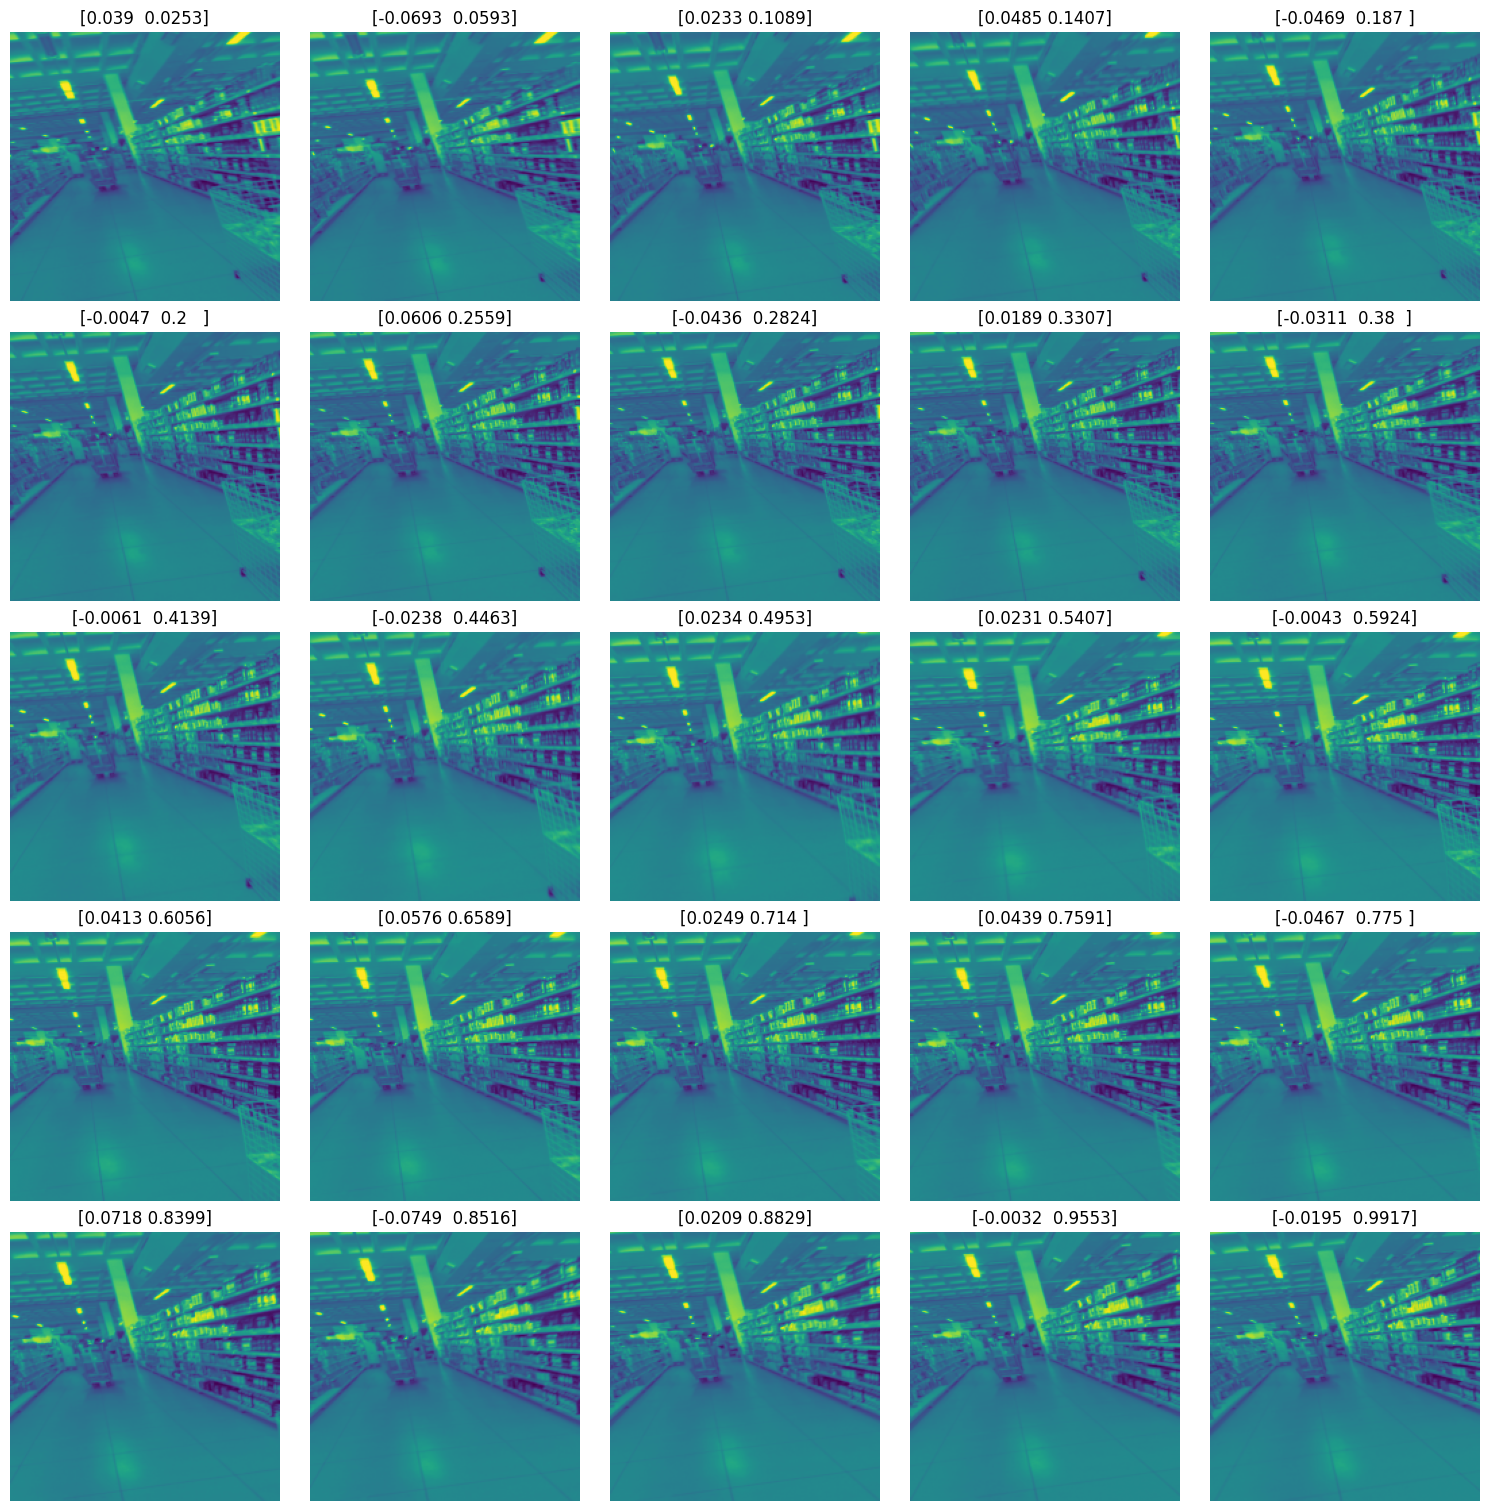

In [6]:
indices = np.arange(0, X.shape[0])
# np.random.shuffle(indices)
indices = indices[:25]

plt.subplots(5, 5, figsize=(15, 15), layout="constrained")
for index, sample_index in enumerate(indices):
    plt.subplot(5, 5, index + 1)
    plt.title(str(y[sample_index]))
    plt.imshow(X[sample_index])
    plt.axis("off")

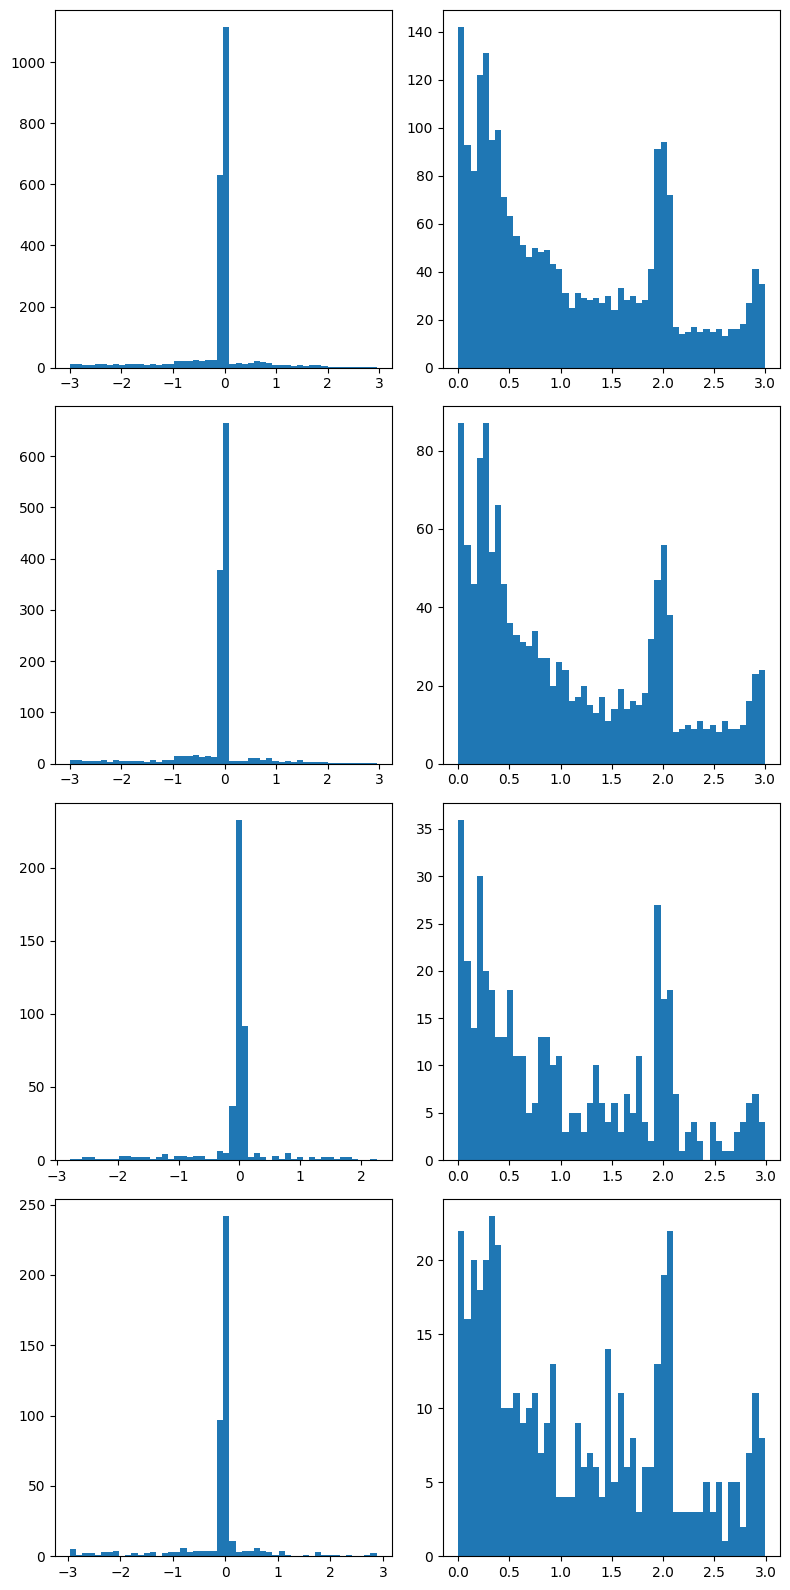

In [7]:
def plot_velocities_distribution(data=[]):
    rows = len(data)
    columns = 2

    fig, ax = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4), layout="tight")

    for i, labels in enumerate(data):
        x_vel = labels[:, 0]
        y_vel = labels[:, 1]

        ax[i, 0].hist(x_vel, bins=50)
        ax[i, 1].hist(y_vel, bins=50)

plot_velocities_distribution([y, y_train, y_test, y_val])

In [8]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_X = np.array([self.X[i] for i in batch_indexes])
        batch_y = np.array([self.y[i] for i in batch_indexes])

        batch_y_dict = {
            "Dronet_output_x": batch_y[:, 0],
            "Dronet_output_y": batch_y[:, 1],
        }

        return batch_X, batch_y_dict

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [9]:
def mae(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
    
def rmse(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def eva(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

def create_dronet(learning_rate, bottom_layers):
    base = keras.models.load_model(DRONET_PATH)
    base.name = "Dronet_cnn_layers"
    base.trainable = False
    
    inputs = base.input
    conv_layers = base.output

    if len(conv_layers.shape) > 2:
        s = keras.layers.Flatten(name="Dronet_flatten")(conv_layers)
    else:
        s = conv_layers  

    s = keras.layers.ReLU(name="Dronet_relu")(s)
    s = keras.layers.Dropout(0.5, name="Dronet_shared_dropout")(s)

    x = s
    i = 0
    for units in bottom_layers:
        i += 1
        dense_name = f"Dropout_x_dense_{i}"

        x = keras.layers.Dense(units, activation="relu", name=dense_name)(x)

    y = s
    i = 0
    for units in bottom_layers:
        i += 1
        dense_name = f"Dropout_y_dense_{i}"

        y = keras.layers.Dense(units, activation="relu", name=dense_name)(y)
    
    outputs = [
        keras.layers.Dense(1, activation="linear", name="Dronet_output_x")(x),
        keras.layers.Dense(1, activation="linear", name="Dronet_output_y")(y),
    ]

    model = keras.Model(inputs=inputs, outputs=outputs, name="Dronet")

    model.compile(
        loss={
            "Dronet_output_x": "mean_squared_error",
            "Dronet_output_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "Dronet_output_x": [eva, rmse, r2_score],
            "Dronet_output_y": [eva, rmse, r2_score],
        },
    )

    return model

Epoch 1/200


I0000 00:00:1742954489.972509      68 service.cc:145] XLA service 0x78b79c007f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742954489.972567      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


21/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -0.0173 - Dronet_output_x_r2_score: -0.0620 - Dronet_output_x_rmse: 0.6741 - Dronet_output_y_eva: 9.4101e-04 - Dronet_output_y_r2_score: -0.6213 - Dronet_output_y_rmse: 1.0144 - loss: 1.5427

I0000 00:00:1742954493.056178      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - Dronet_output_x_eva: 0.0424 - Dronet_output_x_r2_score: -4.5309e-04 - Dronet_output_x_rmse: 0.6498 - Dronet_output_y_eva: 0.0767 - Dronet_output_y_r2_score: -0.3505 - Dronet_output_y_rmse: 0.9379 - loss: 1.3646 - val_Dronet_output_x_eva: 0.3460 - val_Dronet_output_x_r2_score: 0.3180 - val_Dronet_output_x_rmse: 0.5567 - val_Dronet_output_y_eva: 0.4568 - val_Dronet_output_y_r2_score: 0.4276 - val_Dronet_output_y_rmse: 0.6554 - val_loss: 0.7654 - learning_rate: 0.0010
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Dronet_output_x_eva: 0.2977 - Dronet_output_x_r2_score: 0.2629 - Dronet_output_x_rmse: 0.5202 - Dronet_output_y_eva: 0.3771 - Dronet_output_y_r2_score: 0.3530 - Dronet_output_y_rmse: 0.6949 - loss: 0.7822 - val_Dronet_output_x_eva: 0.4417 - val_Dronet_output_x_r2_score: 0.4162 - val_Dronet_output_x_rmse: 0.5083 - val_Dronet_output_y_eva: 0.5874 - val_Dronet_output_y_r2_score: 0.4733 - val_Dronet_output_y_rmse: 0.6231 - val_loss: 0

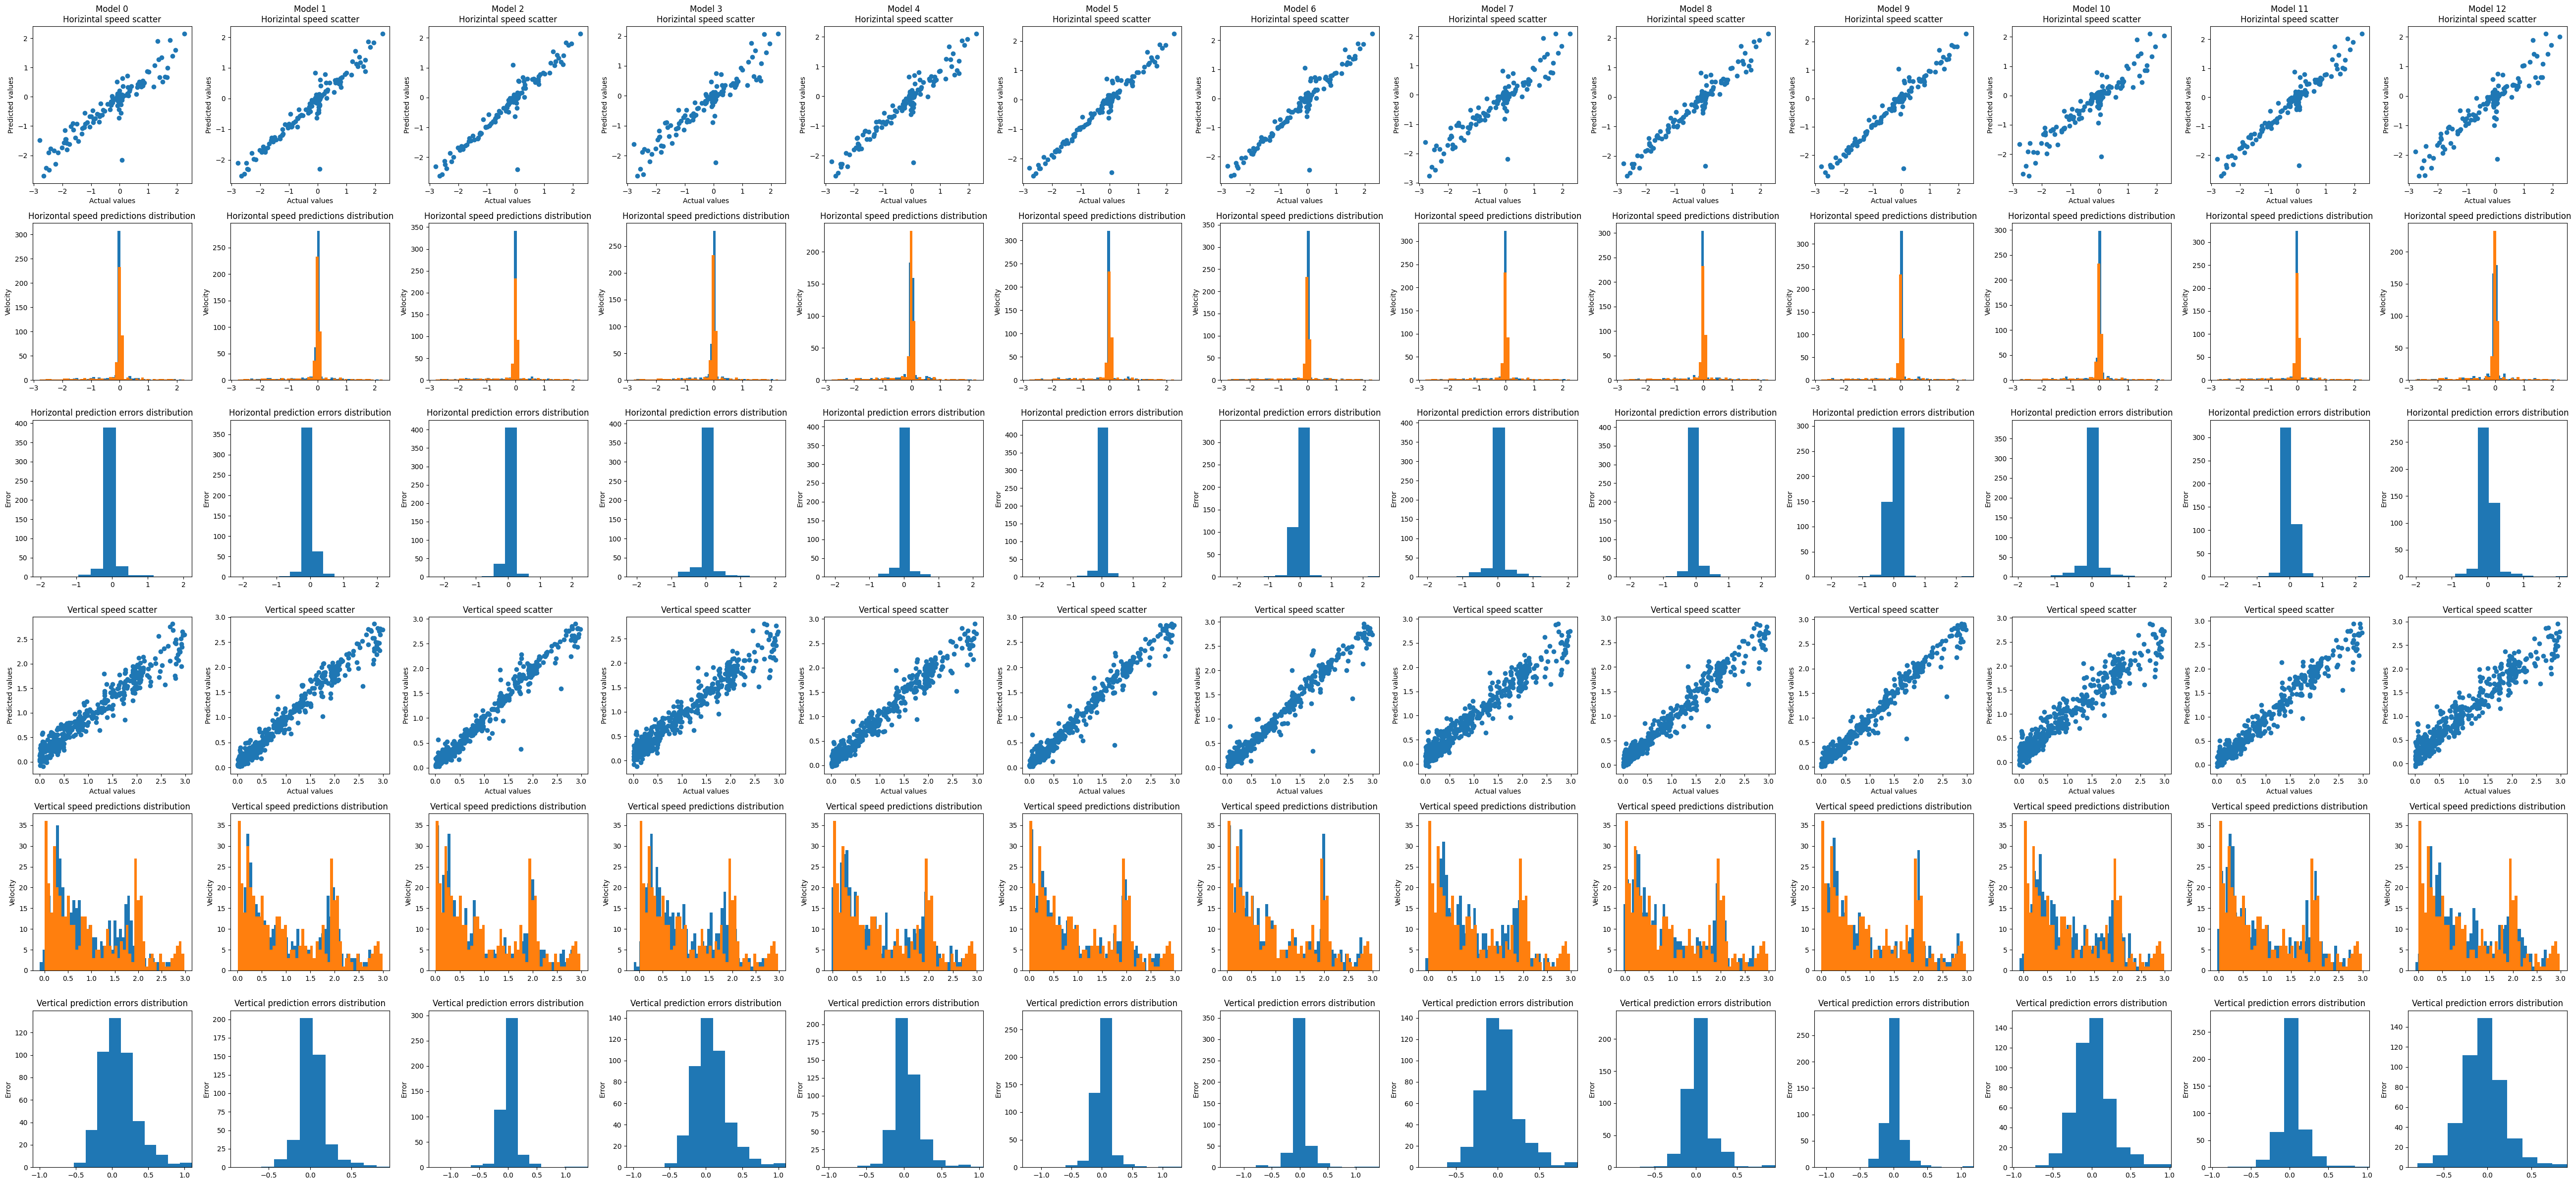

In [10]:
data = {}

dronets = [
    create_dronet(0.001, (2048,)),
    create_dronet(0.001, (2048, 1024,)),
    create_dronet(0.001, (2048, 1024, 512)),
    create_dronet(0.001, (1024,)),
    create_dronet(0.001, (1024, 512)),
    create_dronet(0.001, (1024, 512, 256)),
    create_dronet(0.001, (1024, 512, 256, 128)),
    create_dronet(0.001, (512,)),
    create_dronet(0.001, (512, 256)),
    create_dronet(0.001, (512, 256, 128)),
    create_dronet(0.001, (256,)),
    create_dronet(0.001, (256, 128)),
    create_dronet(0.001, (128,)),
]

y_train_scaled = y_train
y_val_scaled = y_val
y_test_scaled = y_test

# Creation of the data generators
train_dataset = DataGenerator(X_train, y_train_scaled)
validation_dataset = DataGenerator(X_val, y_val_scaled)
test_dataset = DataGenerator(X_test, y_test_scaled)

rows = 6
columns = len(dronets)
figsize = (columns * 4, rows * 4)

fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="tight")
if len(ax.shape) == 1:
    ax = np.array([ax])
    ax = ax.T

for i, dronet in enumerate(dronets):
    column_name = f"Model {i}"

    # Training
    history = dronet.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=200,
        callbacks=[
            # keras.callbacks.EarlyStopping(
            #     monitor="val_Dronet_output_x_rmse",
            #     patience=20,
            #     min_delta=0.0001,
            #     mode="min"
            # ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_Dronet_output_x_rmse",
                patience=10,
                factor=0.5,
                min_lr=1e-7,
                mode="min"
            ),
        ],
        # verbose=0,
    )

    # Evaluation
    metric_names = [
        "MSE", "Horizontal EVA", "Horizontal R²","Horizontal RMSE",
        "Vertical EVA", "Vertical R²", "Vertical RMSE"
    ]
    metric_values = dronet.evaluate(test_dataset)
    data[column_name] = dict(zip(metric_names, metric_values))
    
    y_pred = dronet.predict(X_test)
    y_pred = np.hstack(y_pred)

    x_residuals = y_test_scaled[:, 0] - y_pred[:, 0]
    x_limits = np.max(np.fabs(x_residuals))
    x_limits = (-x_limits, +x_limits)

    y_residuals = y_test_scaled[:, 1] - y_pred[:, 1]
    y_limits = np.max(np.fabs(y_residuals))
    y_limits = (-y_limits, +y_limits)

    ax[0, i].scatter(y_test_scaled[:, 0], y_pred[:, 0])
    ax[0, i].set_title(f"{column_name}\nHorizintal speed scatter")
    ax[0, i].set_xlabel("Actual values")
    ax[0, i].set_ylabel("Predicted values")
    
    ax[1, i].hist(y_pred[:, 0], bins=50)
    ax[1, i].hist(y_test_scaled[:, 0], bins=50)
    ax[1, i].set_title("Horizontal speed predictions distribution")
    ax[1, i].set_ylabel("Velocity")
    
    ax[2, i].hist(x_residuals)
    ax[2, i].set_title("Horizontal prediction errors distribution")
    ax[2, i].set_ylabel("Error")
    ax[2, i].set_xlim(x_limits)

    ax[3, i].scatter(y_test_scaled[:, 1], y_pred[:, 1])
    ax[3, i].set_title("Vertical speed scatter")
    ax[3, i].set_xlabel("Actual values")
    ax[3, i].set_ylabel("Predicted values")
    
    ax[4, i].hist(y_pred[:, 1], bins=50)
    ax[4, i].hist(y_test_scaled[:, 1], bins=50)
    ax[4, i].set_title("Vertical speed predictions distribution")
    ax[4, i].set_ylabel("Velocity")
    
    ax[5, i].hist(y_residuals)
    ax[5, i].set_title("Vertical prediction errors distribution")
    ax[5, i].set_ylabel("Error")
    ax[5, i].set_xlim(y_limits)

metrics = pd.DataFrame(data)
print(metrics.T)